In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import tempfile
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
mpl.rcParams['figure.figsize'] = (12, 4)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
warnings.filterwarnings('ignore')

#custom functions
import os, sys
sys.path.insert(0, '..')
from src.models.config import DNN_CONFIG, SEED
from src.utils import performance_rank_df, performance_rank_n, performance_rank_f1_opt
from src.utils import plot_precision_recall, plot_loss, plot_auc, plot_history, plot_metrics, plot_rank
from src.utils import save_report_json, save_report_pandas_to_csv
from src.utils import save_model, save_model_parameters_pkl, save_model_keras

from src.utils import reset_random_seeds
from src.models.dnn import build_dnn_model, fit_dnn_model

import os
os.environ['PYTHONHASHSEED']=str(SEED)
import numpy as np
np.random.seed(SEED)
np.set_printoptions(precision=4)
import random as python_random
python_random.seed(SEED)
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight

Using TensorFlow backend.


In [9]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Test reproducibility

During development of a model, sometimes it is useful to be able to obtain reproducible results from run to run in order to determine if a change in performance is due to an actual model or data modification, or merely a result of a new random seed.

First, you need to set the PYTHONHASHSEED environment variable before the program starts (not within the program itself). This is necessary in Python 3.2.3 onwards to have reproducible behavior for certain hash-based operations.

Moreover, whenrunning on a GPU, some operations have non-deterministic outputs, in particular tf.reduce_sum(). This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed.

Keras FAQ - (https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)


In [73]:
# from tests.tf_tests import test_reproducibility_tf
# test_reproducibility_tf()

# Read data

In [11]:
df = pd.read_csv('../data/raw/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.shape

(284807, 31)

In [13]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
pos / total

0.001727485630620034

# Data pre-processing

In [14]:
y=df['Class']
X=df.drop('Class',1)

X['Amount_log'] = np.log(X['Amount'] + 1)
X=X.drop(['Amount','Time'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


In [15]:
# configure our pipeline
pipeline_st = Pipeline([('scaler', StandardScaler())])

# get normalization parameters by fitting to the training data
pipeline_st.fit(X_train)

# transform the training and validation data with these parameters
X_train_st = pipeline_st.transform(X_train)
X_val_st = pipeline_st.transform(X_val)
X_test_st = pipeline_st.transform(X_test)

# configure our pipeline
pipeline_mm = Pipeline([
                    #  ('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())
                     ])

# get normalization parameters by fitting to the training data
pipeline_mm.fit(X_train)

# transform the training and validation data with these parameters
X_train_mm = pipeline_mm.transform(X_train)
X_val_mm = pipeline_mm.transform(X_val)
X_test_mm = pipeline_mm.transform(X_test)

# Model optimization

## Model capacity optimization

Keras models can be used in scikit-learn by wrapping them with the KerasClassifier

In [16]:
# Define a series of parameters
params = dict(n_layers=[0, 1, 2], 
              n_neurons=[32, 64, 128],
              learning_rate=[0.1, 0.01,  0.001])
# simple early stopping
es = EarlyStopping(
    monitor='val_auc', 
    mode='max', 
    verbose=0, 
    patience=3,
    restore_best_weights=True)

callbacks = [es]
fit_params = {   
    'callbacks': callbacks,
    'validation_data': (X_val, y_val),
    'verbose': 0
}


# Create a model as a sklearn estimator
model = KerasClassifier(
    build_fn=build_dnn_model, 
    epochs=200, 
    batch_size=2042)

# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, 
                                   param_distributions=params,
                                   cv=3, 
                                   scoring="roc_auc",
                                   n_iter = 12,
                                   random_state=SEED)

In [17]:
%%time
random_search_results = random_search.fit(X_train, y_train, **fit_params, shuffle=False)

# Print results
print("Best: %f using %s" % (random_search_results.best_score_,random_search_results.best_params_))

df_random_search_results = pd.DataFrame.from_dict(random_search_results.cv_results_['params'])
df_random_search_results["mean_auc"] = random_search_results.cv_results_['mean_test_score']
df_random_search_results["std_auc"] = random_search_results.cv_results_['std_test_score']
df_random_search_results.sort_values("mean_auc", ascending = False)

Best: 0.966720 using {'n_neurons': 64, 'n_layers': 1, 'learning_rate': 0.01}
Wall time: 12min 19s


,n_neurons,n_layers,learning_rate,mean_auc,std_auc
1,64,1,0.010,0.966720,0.010555
7,128,2,0.010,0.966700,0.008575
6,64,2,0.010,0.966179,0.009710
3,32,1,0.001,0.958956,0.014128
8,32,1,0.010,0.958117,0.013721
2,32,0,0.010,0.957653,0.018078
11,64,1,0.100,0.956803,0.009652
9,32,2,0.001,0.955989,0.013556
5,128,0,0.010,0.949203,0.005366
4,32,0,0.100,0.945786,0.002092


In [18]:
save_report_pandas_to_csv(df_random_search_results, 'dnn_cv_results')
save_model_parameters_pkl(random_search_results.best_params_, 'random_search_results_best_params')

### Baseline model with tuned capacity

In [19]:
best_capacity_params = random_search_results.best_params_
best_capacity_params

{'n_neurons': 64, 'n_layers': 1, 'learning_rate': 0.01}

In [20]:
dnn_baseline = build_dnn_model(**best_capacity_params)
dnn_baseline.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (Dense)          (None, 64)                1920      
_________________________________________________________________
dense_0 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_37 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


In [21]:
baseline = fit_dnn_model(    
    dnn_baseline,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline',
    )

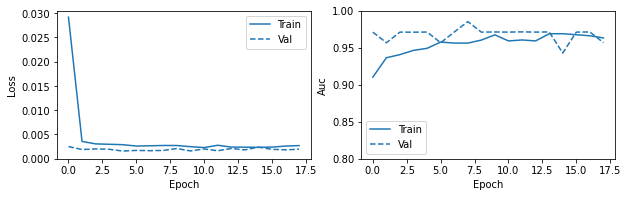

In [22]:
plot_history(baseline, 0)

In [23]:
df_pf_baseline = performance_rank_df(y_test, dnn_baseline.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_baseline)

,Precision,Recall,F1_score
Rank,,,
100,0.7800,0.795918,0.787879
500,0.1760,0.897959,0.294314
1000,0.0880,0.897959,0.160291
10000,0.0094,0.959184,0.018618


## Baseline optimization with dropout, and batch normalization

Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. — Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, 2015.

### Baseline with dropout

In [24]:
dnn_baseline_do = build_dnn_model(**best_capacity_params, dropout = True)
dnn_baseline_do.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (Dense)          (None, 64)                1920      
_________________________________________________________________
DO_input (Dropout)           (None, 64)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_38 (Activation)   (None, 64)                0         
_________________________________________________________________
DO_0 (Dropout)               (None, 64)                0         
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
___________________________________________________

In [25]:
baseline_do = fit_dnn_model(    
    dnn_baseline_do,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline_do',
    )

In [26]:
df_pf_baseline_do = performance_rank_df(y_test, dnn_baseline_do.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_baseline_do)

,Precision,Recall,F1_score
Rank,,,
100,0.7800,0.795918,0.787879
500,0.1760,0.897959,0.294314
1000,0.0880,0.897959,0.160291
10000,0.0094,0.959184,0.018618


### Baseline with Batch Normalization

Batch normalization reparametrizes the model to make some units always be standardized by definition

The goal of Batch Normalization is to achieve a stable distribution of activation values throughout training, and in our experiments we apply it **before the nonlinearity** since that is where matching the first and second moments is more likely to result in a stable distribution — Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, 2015.

In [27]:
dnn_baseline_bn = build_dnn_model(**best_capacity_params, batchnorm = True)
dnn_baseline_bn.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (Dense)          (None, 64)                1920      
_________________________________________________________________
BN_input (BatchNormalization (None, 64)                256       
_________________________________________________________________
activation_39 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                4160      
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
activation_40 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_output (Dense)         (None, 1)               

In [28]:
baseline_bn = fit_dnn_model(    
    dnn_baseline_bn,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline_bn',
    )

In [29]:
df_pf_baseline_bn = performance_rank_df(y_test, dnn_baseline_bn.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_baseline_bn)

,Precision,Recall,F1_score
Rank,,,
100,0.8000,0.816327,0.808081
500,0.1720,0.877551,0.287625
1000,0.0870,0.887755,0.158470
10000,0.0092,0.938776,0.018221


### Baseline with Dropout and Batch Normalization

In [30]:
dnn_baseline_do_bn = build_dnn_model(**best_capacity_params, dropout = True, batchnorm = True)
dnn_baseline_do_bn.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (Dense)          (None, 64)                1920      
_________________________________________________________________
BN_input (BatchNormalization (None, 64)                256       
_________________________________________________________________
activation_41 (Activation)   (None, 64)                0         
_________________________________________________________________
DO_input (Dropout)           (None, 64)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                4160      
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
activation_42 (Activation)   (None, 64)              

In [31]:
baseline_do_bn = fit_dnn_model(    
    dnn_baseline_do_bn,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline_do_bn',
    )

In [32]:
df_pf_baseline_do_bn = performance_rank_df(y_test, dnn_baseline_do_bn.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_baseline_do_bn)

,Precision,Recall,F1_score
Rank,,,
100,0.7900,0.806122,0.797980
500,0.1780,0.908163,0.297659
1000,0.0900,0.918367,0.163934
10000,0.0095,0.969388,0.018816


### Compare baseline models

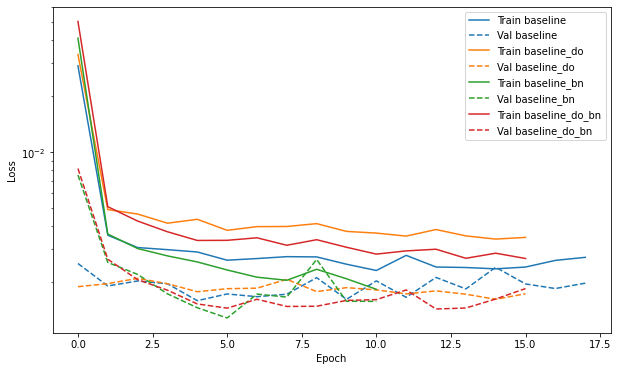

In [33]:
plot_loss(baseline, "baseline", 0)
plot_loss(baseline_do, "baseline_do", 1)
plot_loss(baseline_bn, "baseline_bn", 2)
plot_loss(baseline_do_bn, "baseline_do_bn", 3)

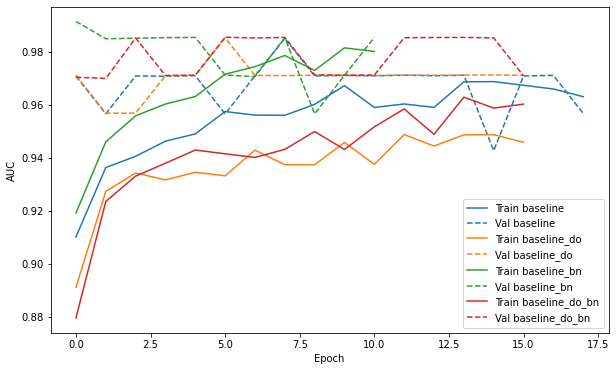

In [34]:
plot_auc(baseline, "baseline", 0)
plot_auc(baseline_do, "baseline_do", 1)
plot_auc(baseline_bn, "baseline_bn", 2)
plot_auc(baseline_do_bn, "baseline_do_bn", 3)

## Model weights optimization

### Baseline with initial bias

In [35]:
dnn_baseline_bn_iw = build_dnn_model(**best_capacity_params, batchnorm = True)

If you have an imbalanced dataset, set the bias on your logits such that your network predicts probability of __positives/negatives__ at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.

In [36]:
dnn_baseline_bn_iw.predict(X_test[:5])

array([[0.9105],
       [0.7765],
       [0.6185],
       [0.5392],
       [0.5992]], dtype=float32)

In [37]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.3594])

In [38]:
dnn_baseline_bn_iw = build_dnn_model(**best_capacity_params, batchnorm = True, output_bias=initial_bias)

In [39]:
dnn_baseline_bn_iw.predict(X_test[:5])

array([[0.0076],
       [0.0026],
       [0.0012],
       [0.0009],
       [0.0011]], dtype=float32)

Predictions are now much closer to the ratio __positives/negatives__ 

In [40]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.h5')
dnn_baseline_bn_iw.save_weights(initial_weights)

In [41]:
dnn_baseline_bn_iw = build_dnn_model(**best_capacity_params, batchnorm = True)
dnn_baseline_bn_iw.load_weights(initial_weights)

baseline_bn_iw = fit_dnn_model(    
    dnn_baseline_bn_iw,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline_bn_iw',
    )

In [42]:
#plot_history(dnn_baseline_do_iw_history)

In [43]:
df_pf_baseline_bn_iw = performance_rank_df(y_test, dnn_baseline_bn_iw.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_baseline_bn_iw)

,Precision,Recall,F1_score
Rank,,,
100,0.8000,0.816327,0.808081
500,0.1780,0.908163,0.297659
1000,0.0890,0.908163,0.162113
10000,0.0095,0.969388,0.018816


### Baseline with batch normalization, initial bias and class weights

In [44]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weights = dict(enumerate(class_weight.compute_class_weight(
    'balanced', np.unique(y_train), y_train)))
weights

<module 'sklearn.utils.class_weight' from 'C:\\Users\\XX18VM\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\sklearn\\utils\\class_weight.py'>

In [45]:
dnn_baseline_bn_iw_cw = build_dnn_model(**best_capacity_params, batchnorm = True)
#dnn_baseline_bn_iw_cw.summary()

In [46]:
# fit model
dnn_baseline_bn_iw_cw.load_weights(initial_weights)
baseline_bn_iw_cw = fit_dnn_model(    
    dnn_baseline_bn_iw_cw,
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    name = 'baseline_bn_iw_cw',
    class_weight=weights
    )

In [47]:
#plot_history(dnn_baseline_do_iw_cw_history)

In [48]:
df_pf_baseline_bn_iw_cw = performance_rank_df(
    y_test, 
    dnn_baseline_bn_iw_cw.predict(X_test)[:,0], 
    if_score = False)
performance_rank_n(df_pf_baseline_bn_iw_cw)

,Precision,Recall,F1_score
Rank,,,
100,0.7100,0.724490,0.717172
500,0.1760,0.897959,0.294314
1000,0.0880,0.897959,0.160291
10000,0.0096,0.979592,0.019014


### Compare final models

In [67]:
models = [
  dnn_baseline, dnn_baseline_do, dnn_baseline_bn, 
  dnn_baseline_bn_iw, dnn_baseline_bn_iw_cw
  ]
models_name = [
  "dnn_baseline", 'dnn_baseline_do', 'dnn_baseline_bn', 
  'dnn_baseline_bn_iw', 'dnn_baseline_bn_iw_cw'
  ]

for i,model in enumerate(models):
  print(models_name[i])
  results = model.evaluate(X_test, y_test, verbose=0)
  for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)


dnn_baseline
loss :  0.0034747628960758448
auc :  0.9480016827583313
dnn_baseline_do
loss :  0.0034255890641361475
auc :  0.9483888149261475
dnn_baseline_bn
loss :  0.008779135532677174
auc :  0.9722596406936646
dnn_baseline_bn_iw
loss :  0.0027288426645100117
auc :  0.9534526467323303
dnn_baseline_bn_iw_cw
loss :  0.07867465913295746
auc :  0.9839616417884827


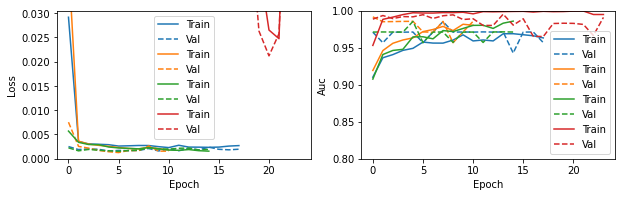

In [68]:
models = [baseline, baseline_bn, baseline_bn_iw, baseline_bn_iw_cw]
plot_metrics(histories = models)

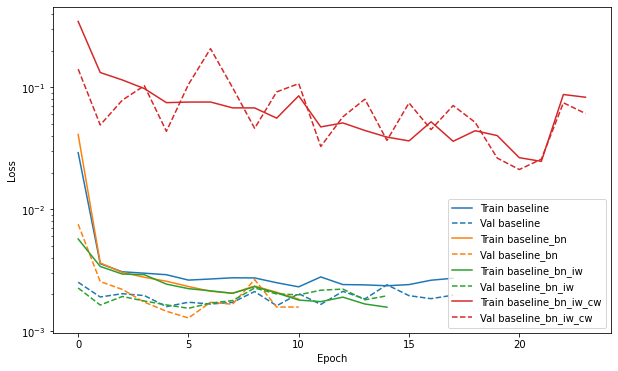

In [69]:
plot_loss(baseline, "baseline", 0)
plot_loss(baseline_bn, "baseline_bn", 1)
plot_loss(baseline_bn_iw, "baseline_bn_iw", 2)
plot_loss(baseline_bn_iw_cw, "baseline_bn_iw_cw", 3)

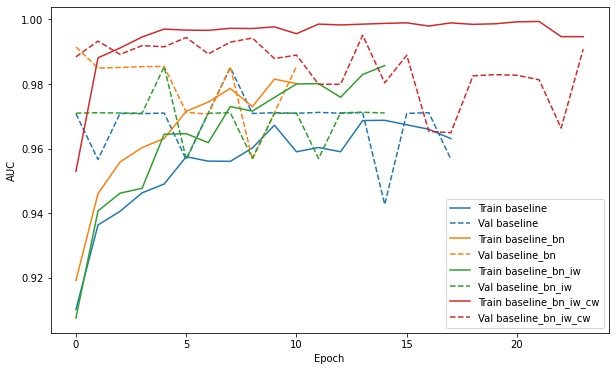

In [70]:
plot_auc(baseline, "baseline", 0)
plot_auc(baseline_bn, "baseline_bn", 1)
plot_auc(baseline_bn_iw, "baseline_bn_iw", 2)
plot_auc(baseline_bn_iw_cw, "baseline_bn_iw_cw", 3)

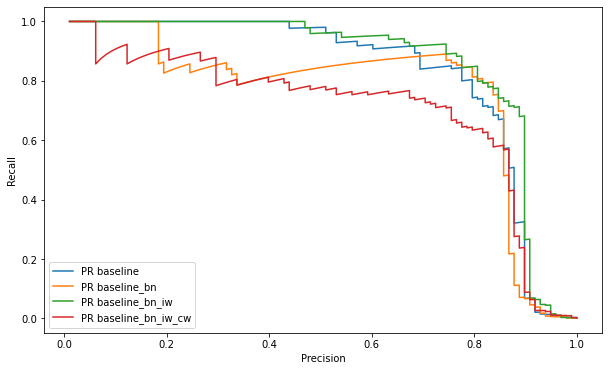

In [60]:
plot_precision_recall(df_pf_baseline, "baseline", 0)
plot_precision_recall(df_pf_baseline_bn, "baseline_bn", 1)
plot_precision_recall(df_pf_baseline_bn_iw, "baseline_bn_iw", 2)
plot_precision_recall(df_pf_baseline_bn_iw_cw, "baseline_bn_iw_cw", 3)

In [65]:
metric_compare = "Recall"

rank_merged = performance_rank_n(df_pf_baseline).merge(
    performance_rank_n(df_pf_baseline_bn), 
    left_index=True, right_index=True, suffixes=("", "_bn")).merge(
        performance_rank_n(df_pf_baseline_bn_iw), 
        left_index=True, right_index=True, suffixes=("", "_bn_wi")).merge(
            performance_rank_n(df_pf_baseline_bn_iw_cw), 
            left_index=True, right_index=True, suffixes=("", "_bn_wi_cw"))
rank_merged[rank_merged.columns[pd.Series(rank_merged.columns).str.startswith(metric_compare)]]

,Recall,Recall_bn,Recall_bn_wi,Recall_bn_wi_cw
Rank,,,,
100,0.795918,0.816327,0.816327,0.724490
500,0.897959,0.877551,0.908163,0.897959
1000,0.897959,0.887755,0.908163,0.897959
10000,0.959184,0.938776,0.969388,0.979592


In [66]:
rank_merged

,Precision,Recall,F1_score,Precision_bn,Recall_bn,F1_score_bn,Precision_bn_wi,Recall_bn_wi,F1_score_bn_wi,Precision_bn_wi_cw,Recall_bn_wi_cw,F1_score_bn_wi_cw
Rank,,,,,,,,,,,,
100,0.7800,0.795918,0.787879,0.8000,0.816327,0.808081,0.8000,0.816327,0.808081,0.7100,0.724490,0.717172
500,0.1760,0.897959,0.294314,0.1720,0.877551,0.287625,0.1780,0.908163,0.297659,0.1760,0.897959,0.294314
1000,0.0880,0.897959,0.160291,0.0870,0.887755,0.158470,0.0890,0.908163,0.162113,0.0880,0.897959,0.160291
10000,0.0094,0.959184,0.018618,0.0092,0.938776,0.018221,0.0095,0.969388,0.018816,0.0096,0.979592,0.019014


# Keras tuner

In [82]:
!pip install -U keras-tuner
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import kerastuner

     |████████████████████████████████| 71kB 9.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=8cc39050ccacb75cadacde148b2b8e84e9605911a99116db9bfc4fc436a82c2c
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=2b879617c5a54842e124674b90e2a30e67cd98cb22ea5b816471199f43e81022
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


First, we define a model-building function. It takes an argument hp from which you can sample hyperparameters

In [83]:
def build_model_tuner(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers', 1, 3)):
      model.add(Dense(units=hp.Int('units_' + str(i),
                                          min_value=32,
                                          max_value=128,
                                          step=32),
                              activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(
      optimizer=tf.keras.optimizers.Adam(
          hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3])),
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.AUC(name="auc")])
  return model


Next, instantiate a tuner. You should specify the model-building function, the name of the objective to optimize (whether to minimize or maximize is automatically inferred for built-in metrics), the total number of trials (max_trials) to test, and the number of models that should be built and fit for each trial (executions_per_trial)

In [84]:
tuner = RandomSearch(
    build_model_tuner,
    objective=kerastuner.Objective("val_auc", direction="max"),
    max_trials=5,
    executions_per_trial=3,
    directory="my_dir",
    project_name="dlanomalydetect",
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


Here's what happens in search: models are built iteratively by calling the model-building function, which populates the hyperparameter space (search space) tracked by the hp object. The tuner progressively explores the space, recording metrics for each configuration.

In [85]:
%%time
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_val, y_val))

Trial 5 Complete [00h 04m 52s]
val_auc: 0.5923223495483398

Best val_auc So Far: 0.9945267836252848
Total elapsed time: 00h 24m 42s
INFO:tensorflow:Oracle triggered exit
CPU times: user 33min 11s, sys: 4min 2s, total: 37min 14s
Wall time: 24min 42s


In [89]:
dnn_keras_tuner = tuner.get_best_models(num_models=1)[0]

In [90]:
tuner.results_summary()

Results summary
Results in my_dir/dlanomalydetect
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 64
learning_rate: 0.001
units_1: 96
units_2: 64
Score: 0.9945267836252848
Trial summary
Hyperparameters:
num_layers: 3
units_0: 64
learning_rate: 0.001
units_1: 64
units_2: 96
Score: 0.9848979711532593
Trial summary
Hyperparameters:
num_layers: 3
units_0: 96
learning_rate: 0.01
units_1: 32
units_2: 32
Score: 0.9825195471445719
Trial summary
Hyperparameters:
num_layers: 1
units_0: 32
learning_rate: 0.01
units_1: 96
units_2: 64
Score: 0.971145768960317
Trial summary
Hyperparameters:
num_layers: 2
units_0: 96
learning_rate: 0.1
units_1: 96
units_2: 32
Score: 0.5923223495483398


In [92]:
# Evaluate the best model.
dnn_keras_tuner.evaluate(X_test, y_test)

1781/1781 [==============================] - 4s 2ms/step - loss: 0.0035 - auc: 0.9316


[0.0032417629845440388, 0.9534497261047363]

In [93]:
df_pf_dnn_keras_tuner = performance_rank_df(y_test, dnn_keras_tuner.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_dnn_keras_tuner)

,Rank,Precision,Recall,F1_score
69995,100,0.7700,0.785714,0.777778
88939,500,0.1760,0.897959,0.294314
151132,1000,0.0900,0.918367,0.163934
131107,10000,0.0097,0.989796,0.019212


In [96]:
dnn_keras_tuner.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                6240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________


In [95]:
# save the best performing model to file
dnn_keras_tuner.save('dnn_keras_tuner.h5')
save_model_to_drive(DRIVE_PATH, dnn_keras_tuner, 'dnn_keras_tuner')

# Autokeras

AutoML refers to techniques for automatically discovering the best-performing model for a given dataset.

When applied to neural networks, this involves both discovering the model architecture and the hyperparameters used to train the model, generally referred to as neural architecture search.

AutoKeras is an open-source library for performing AutoML for deep learning models. The search is performed using so-called Keras models via the TensorFlow tf.keras API.

It provides a simple and effective approach for automatically finding top-performing models for a wide range of predictive modeling tasks, including tabular or so-called structured classification and regression datasets.

In [98]:
!pip3 install autokeras
from autokeras import StructuredDataClassifier

     |████████████████████████████████| 174kB 17.5MB/s 


In [61]:
# define the search
search = StructuredDataClassifier(
    overwrite=True,
    max_trials=20,
    metrics=[tf.keras.metrics.AUC(name="auc")],
    objective=kerastuner.Objective("val_auc", direction="max"),
    seed=SEED)

In [62]:
%%time
# perform the search
search.fit(x=X_train, 
           y=y_train, 
           validation_data=(X_val, y_val),
           verbose=1)

Trial 20 Complete [00h 05m 48s]
val_auc: 0.9713442921638489

Best val_auc So Far: 0.9713895916938782
Total elapsed time: 02h 36m 15s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
CPU times: user 3h 29min 40s, sys: 22min 53s, total: 3h 52min 33s
Wall time: 2h 36min 32s


In [63]:
# evaluate the model
search.evaluate(X_test, y_test, verbose=0)

[0.005146909039467573, 0.9335451722145081]

In [64]:
# get the best performing model
dnn_best_autokeras = search.export_model()
# summarize the loaded model
dnn_best_autokeras.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 30)                0         
_________________________________________________________________
normalization (Normalization (None, 30)                61        
_________________________________________________________________
dense (Dense)                (None, 512)               15872     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312

In [66]:
# save the best performing model to file
save_model_keras(dnn_best_autokeras, 'dnn_autokeras')

In [99]:
# load autokeras model
dnn_best_autokeras = load_model(os.path.join(DRIVE_PATH,'dnn_autokeras.h5'))

In [100]:
dnn_best_autokeras.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 30)                0         
_________________________________________________________________
normalization (Normalization (None, 30)                61        
_________________________________________________________________
dense (Dense)                (None, 512)               15872     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312

In [101]:
df_pf_dnn_best_autokeras = performance_rank_df(y_test, dnn_best_autokeras.predict(X_test)[:,0], if_score = False)
performance_rank_n(df_pf_dnn_best_autokeras)

,Rank,Precision,Recall,F1_score
164955,100,0.8200,0.836735,0.828283
154606,500,0.1760,0.897959,0.294314
46878,1000,0.0880,0.897959,0.160291
91292,10000,0.0093,0.948980,0.018419


# To Do
- Test reproducibility when saving weights
- Test reproducibility when using Batch Normalization